<a href="https://colab.research.google.com/github/Quillbolt/colabnotebook/blob/main/refinedet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/dd604/refinedet.pytorch.git

Cloning into 'refinedet.pytorch'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 919 (delta 81), reused 198 (delta 80), pack-reused 706
Receiving objects: 100% (919/919), 10.86 MiB | 36.09 MiB/s, done.
Resolving deltas: 100% (585/585), done.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data as data
from PIL import Image
import cv2

In [ ]:
import os
import sys
root_path = os.path.abspath(os.path.join('/content/refinedet.pytorch'))
sys.path.append(root_path)

In [ ]:
from libs.networks.vgg_refinedet import VGGRefineDet
from libs.networks.resnet_refinedet import ResNetRefineDet
from libs.utils.config import voc320, MEANS, coco320
from libs.data_layers.transform import base_transform
from matplotlib import pyplot as plt

In [ ]:
is_gpu = False
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    is_gpu = True

In [ ]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [ ]:
number_of_unique_elements = len(set(CLASSES))

In [ ]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list

In [ ]:
unique(CLASSES) 

['N/A',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [ ]:
num_classes = len(CLASSES)

In [ ]:
cfg = coco320

In [ ]:
base_network = 'resnet101'
model_path = '/content/drive/MyDrive/resnet101_refinedet320_coco_400000.pth'
print('Construct {}_refinedet network.'.format(base_network))
refinedet = ResNetRefineDet(cfg['num_classes'], cfg)
refinedet.create_architecture()
# For CPU
net = refinedet
# For GPU/GPUs
if is_gpu:
    net = refinedet.cuda()
    cudnn.benchmark = True
# Load weights
net.load_weights(model_path)
net.eval()

Construct resnet101_refinedet network.
Initializing weights...


/content/refinedet.pytorch/libs/utils/net_utils.py:51: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=1, std=0.02)


ResNetRefineDet(
  (detect_layer): Detect()
  (arm_loss_layer): ARMLoss()
  (odm_loss_layer): ODMLoss()
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

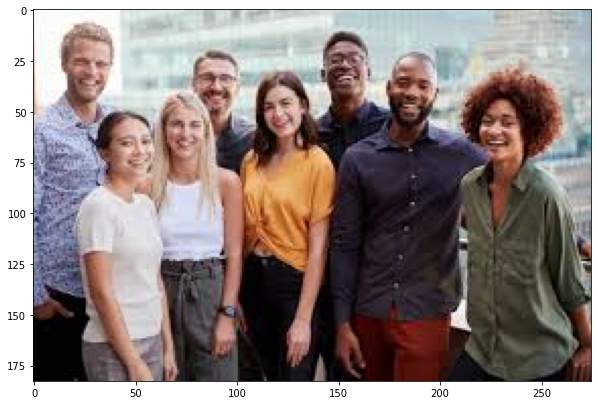

In [ ]:
img_path = '/content/drive/MyDrive/p1.jpeg'
image = cv2.imread(img_path, cv2.IMREAD_COLOR)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

IndexError: ignored

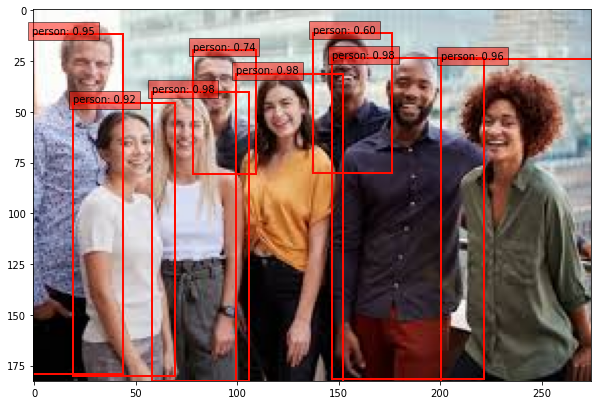

In [ ]:
norm_image = cv2.resize(image, (320, 320)).astype(np.float32)
norm_image -= MEANS
norm_image = norm_image.astype(np.float32)
norm_image = torch.from_numpy(norm_image).permute(2, 0, 1)

# forward
input_var = Variable(norm_image.unsqueeze(0))  # wrap tensor in Variable
if torch.cuda.is_available():
    input_var = input_var.cuda()
detection = net(input_var)

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, num_classes)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# scale each detection back up to the image,
# scale = (width, height, width, height)
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
threshold = 0.5
num_top = detection.size(2)

for i in range(1, num_classes):
    for j in range(num_top):
        score = detection[0, i, j, 0]
        if score < threshold:
            continue
        label_name = CLASSES[i]
        display_txt = '%s: %.2f' % (label_name, score)
        pt = (detection[0, i, j, 1:] * scale).cpu().numpy()
#         print(pt)
        coords = (pt[0], pt[1]), pt[2] - pt[0] + 1, \
                 pt[3] - pt[1] + 1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, 
            fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, 
            bbox={'facecolor':color, 'alpha':0.5})
